In [1]:
#@title
!git clone https://github.com/facebookresearch/BenchMARL
#@title
%cd /content/BenchMARL
#@title
!pip install -U torch torchvision
!pip install -e .
#@title
!pip install dm-meltingpot
!apt-get update
!apt-get install -y x11-utils
!apt-get install -y xvfb
!apt-get install -y imagemagick
!pip install pyvirtualdisplay
!pip install id-marl-eval
!apt-get install python3-opengl
!pip install --upgrade chex
!pip install wandb
!pip install vmas[all]
!python -m pip install vmas
!python -c "import vmas; print(vmas.__version__)"
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
display.start()

fatal: destination path 'BenchMARL' already exists and is not an empty directory.
/content/BenchMARL
Obtaining file:///content/BenchMARL
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for benchmarl (pyproject.toml) ... done
  Created wheel for benchmarl: filename=benchmarl-1.3.0-0.editable-py3-none-any.whl size=3762 sha256=986dd90530e04a1bedf35986197bea4c4cee0cf999f84f9638a8100852dd2fe1
  Stored in directory: /tmp/pip-ephem-wheel-cache-9aw2rjb3/wheels/5b/86/4d/eff20c27275b75bdf6b20e4a81af849509b0068ff4c44be9df
Successfully built benchmarl
  Attempting uninstall: benchmarl
    Found existing installation: benchmarl 1.3.0
    Uninstalling benchmarl-1.3.0:
      Successfully uninstalled benchmarl-1.3.0
  Using cached chex-0.1.7-py3-none-any.whl.metadata (17 kB)
Using cached chex-0.1.7-py3-none-any.whl (89 kB)
 

In [2]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 01019799 (01019799-marcingodniak). Use `wandb login --relogin` to force relogin


True

/content/BenchMARL/benchmarl/environments/magent/common.py:45: DeprecationWarning: private variables, such as '_MAgentTask__get_env', will be normal attributes in 3.11
  def __get_env(self, config) -> EnvBase:
/usr/local/lib/python3.10/dist-packages/colorcet/__init__.py:82: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  register_cmap("cet_"+name, cmap=cm[name])


Created benchmark with 4 experiments.


/usr/local/lib/python3.10/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py:202: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  settings = self._wl.settings.copy()
wandb: Currently logged in as: 01019799 (01019799-marcingodniak). Use `wandb login --relogin` to force relogin


  0%|          | 0/10 [00:00<?, ?it/s]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/fx/painting.py:7: DeprecationWarning: Please import `sobel` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import sobel

mean return = -524.8851928710938: 100%|██████████| 10/10 [03:17<00:00, 19.48s/it]

collection/agents/reward/episode_reward_max,▇▄▂▂▁█▂▄▅▅
collection/agents/reward/episode_reward_mean,▃▄▃▃▄▁▆▄▅█
collection/agents/reward/episode_reward_min,▇▆▁▄▁▆▅█▂▇
collection/reward/episode_reward_max,▇▄▂▂▁█▂▄▅▅
collection/reward/episode_reward_mean,▃▄▃▃▄▁▆▄▅█
collection/reward/episode_reward_min,▇▆▁▄▁▆▅█▂▇
collection/reward/reward_max,▅▇▃▂▁▇█▆▅▄
collection/reward/reward_mean,▃▄▃▃▄▁▆▄▅█
collection/reward/reward_min,▆▆▂▁▂▅██▁▄
counters/current_frames,▁▁▁▁▁▁▁▁▁▁
counters/iter,▁▂▃▃▄▅▆▆▇█


  lambda data: self._console_raw_callback("stderr", data),

mean return = -524.8851928710938: 100%|██████████| 10/10 [03:20<00:00, 20.01s/it]
  settings = self._wl.settings.copy()



mean return = -42.13432312011719: 100%|██████████| 10/10 [05:20<00:00, 31.54s/it]

collection/adversary/reward/episode_reward_max,▁▆▇▄▆▅█▇▄▆
collection/adversary/reward/episode_reward_mean,▅▃▅▃▁█▄▅▄▄
collection/adversary/reward/episode_reward_min,█▃▃▁▄▅▃▇▄▆
collection/agent/reward/episode_reward_max,▁█▅▆▃▁▃▂▄▆
collection/agent/reward/episode_reward_mean,▁█▆▆▅▁█▄▃▂
collection/agent/reward/episode_reward_min,▇█▇▇▇▅█▄▁▆
collection/reward/episode_reward_max,▁▇▇▅▆▄▃█▅▃
collection/reward/episode_reward_mean,▃▇▇▄▁▆█▆▂▁
collection/reward/episode_reward_min,▅█▆▆▅▆▆▆▁▃
collection/reward/reward_max,▂█▄▆▃▁▃▂▃▅
collection/reward/reward_mean,▁█▆▆▅▁█▄▃▂


  lambda data: self._console_raw_callback("stderr", data),

mean return = -42.13432312011719: 100%|██████████| 10/10 [05:23<00:00, 32.31s/it]


mean return = -520.33154296875: 100%|██████████| 10/10 [02:57<00:00, 17.65s/it] 

collection/agents/reward/episode_reward_max,█▄▂▁▂█▆▃▄▅
collection/agents/reward/episode_reward_mean,▂▂▂▂▃▁▅▃▅█
collection/agents/reward/episode_reward_min,▇▄▁▅▂▆▆▇██
collection/reward/episode_reward_max,█▄▂▁▂█▆▃▄▅
collection/reward/episode_reward_mean,▂▂▂▂▃▁▅▃▅█
collection/reward/episode_reward_min,▇▄▁▅▂▆▆▇██
collection/reward/reward_max,▅▁▁▂▃▆█▅▅▃
collection/reward/reward_mean,▂▂▂▂▃▁▅▃▅█
collection/reward/reward_min,▇▁▄▅▅▇▇▆▅█
counters/current_frames,▁▁▁▁▁▁▁▁▁▁
counters/iter,▁▂▃▃▄▅▆▆▇█


  lambda data: self._console_raw_callback("stderr", data),

mean return = -520.33154296875: 100%|██████████| 10/10 [02:59<00:00, 18.00s/it]


mean return = -41.256187438964844: 100%|██████████| 10/10 [05:13<00:00, 31.21s/it]

collection/adversary/reward/episode_reward_max,▁▆▇▄▆▄█▇▄▆
collection/adversary/reward/episode_reward_mean,▅▃▅▃▁█▄▅▄▄
collection/adversary/reward/episode_reward_min,█▃▃▁▄▅▃▇▄▆
collection/agent/reward/episode_reward_max,▁█▅▆▃▁▄▂▄▆
collection/agent/reward/episode_reward_mean,▁█▆▆▅▁█▆▃▂
collection/agent/reward/episode_reward_min,▇█▇█▇▅█▄▁▆
collection/reward/episode_reward_max,▁▆▅▂▆▅▃█▅▄
collection/reward/episode_reward_mean,▃▇▇▄▁▆█▇▃▂
collection/reward/episode_reward_min,▅█▆▆▅▇▆▆▁▃
collection/reward/reward_max,▂█▄▆▃▁▄▂▃▅
collection/reward/reward_mean,▁█▆▆▅▁█▆▃▂


  lambda data: self._console_raw_callback("stderr", data),

mean return = -41.256187438964844: 100%|██████████| 10/10 [05:16<00:00, 31.60s/it]


The tabular results are stored in ./aggregated_score_return.csv and they are the following
                              ISAC              MASAC
Median          0.99 [0.99, 0.99]  0.95 [0.95, 0.95]
IQM             0.99 [0.99, 0.99]  0.95 [0.95, 0.95]
Mean            0.99 [0.99, 0.99]  0.95 [0.95, 0.95]
Optimality Gap  0.01 [0.01, 0.01]  0.05 [0.05, 0.05]
The latex tabular results are stored in ./aggregated_score_return_latex.txt


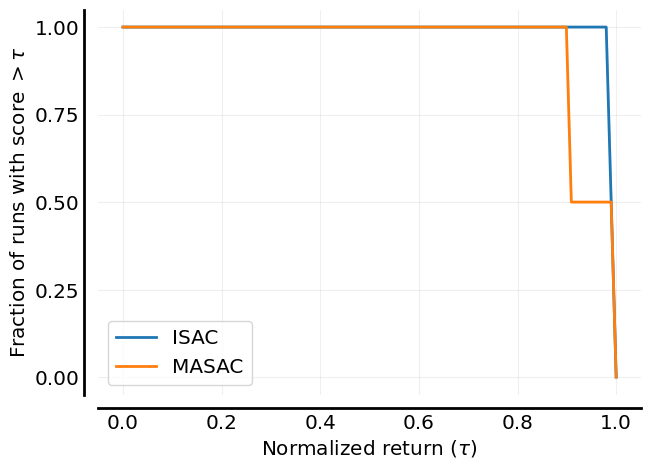

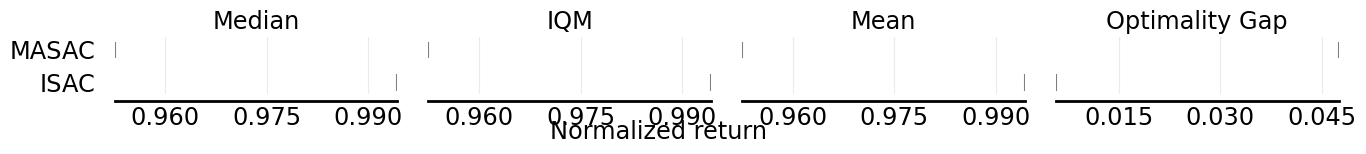

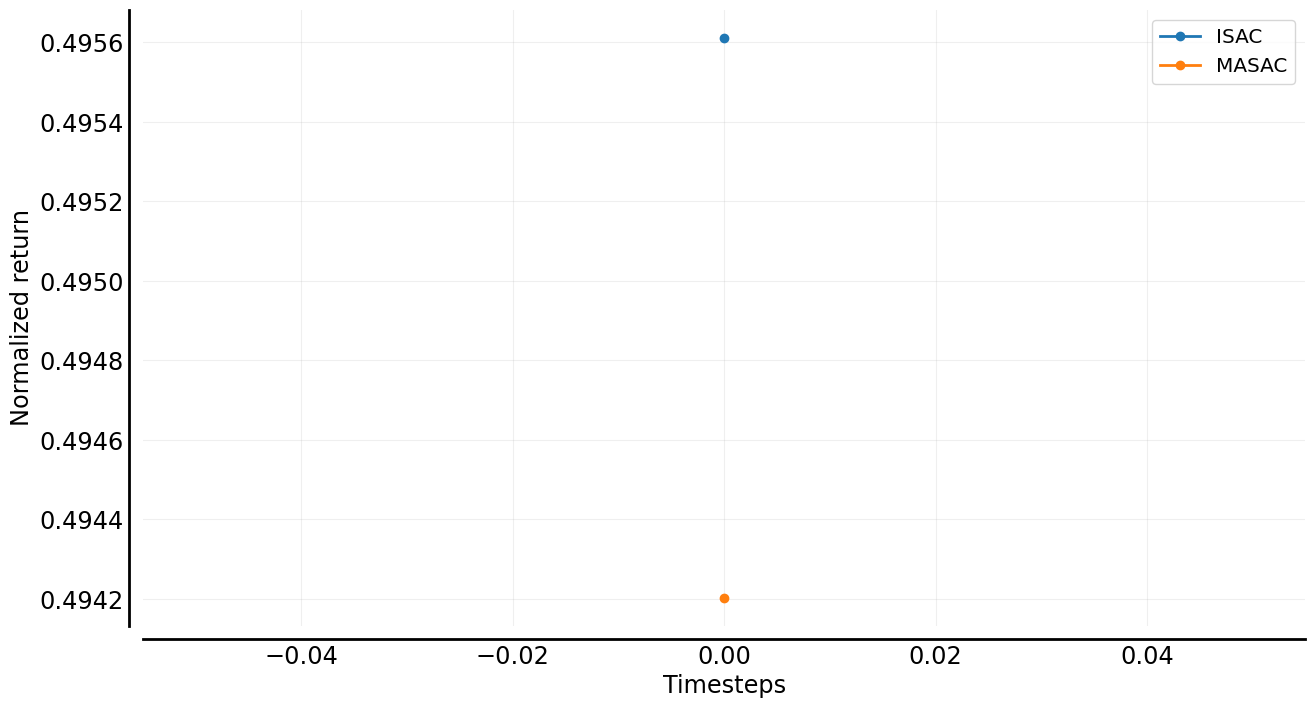

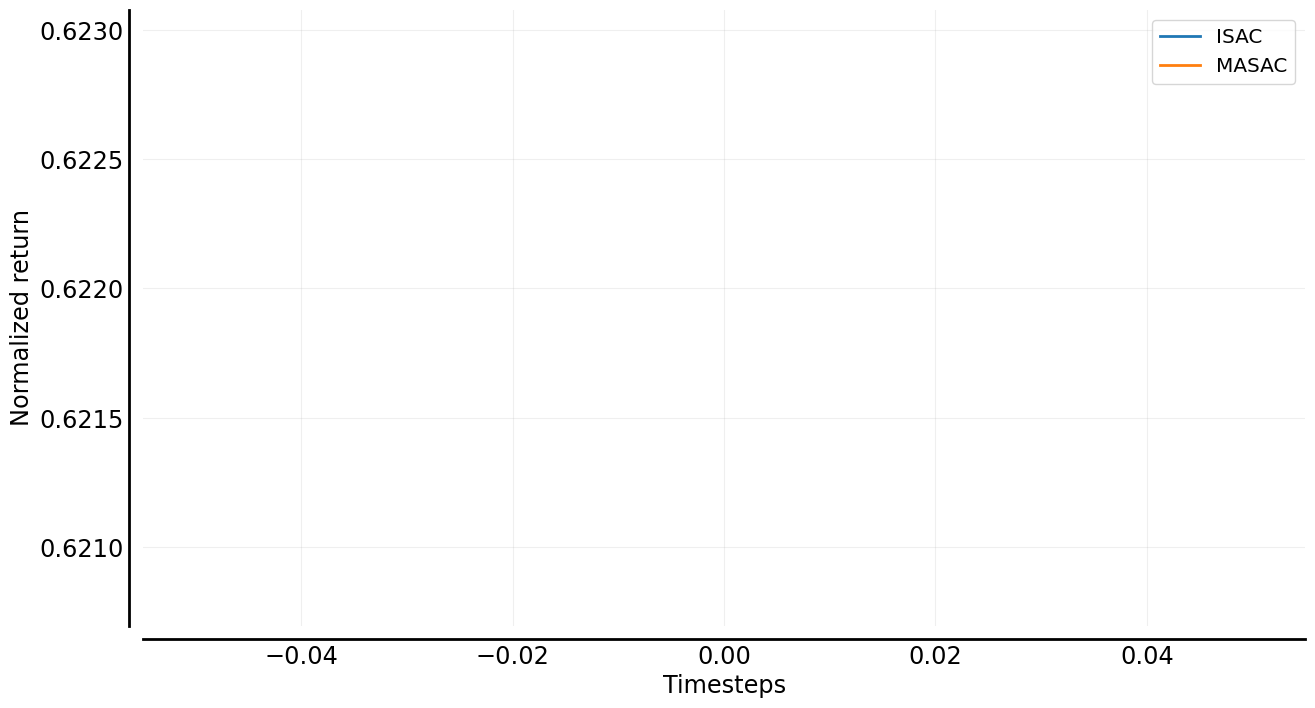

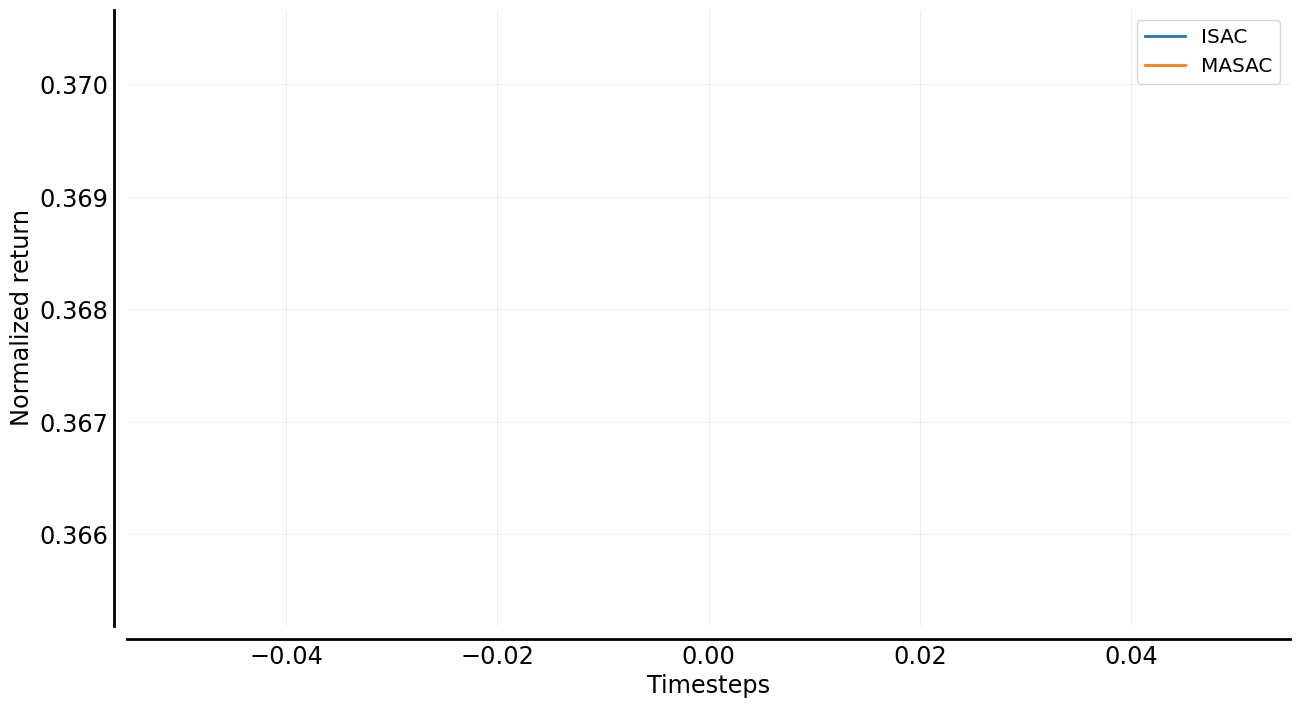

In [1]:
import os
from pathlib import Path
from typing import List

from benchmarl.eval_results import load_and_merge_json_dicts, Plotting
from matplotlib import pyplot as plt

def run_benchmark() -> List[str]:
    from benchmarl.algorithms import IsacConfig, MasacConfig
    from benchmarl.benchmark import Benchmark
    from benchmarl.environments import VmasTask
    from benchmarl.experiment import ExperimentConfig
    from benchmarl.models.mlp import MlpConfig

    # Configure experiment
    experiment_config = ExperimentConfig.get_from_yaml()
    experiment_config.save_folder = Path.cwd()
    experiment_config.loggers = []
    experiment_config.loggers = ["wandb"]
    experiment_config.max_n_iters = 10

    # Tasks: Cooperative and Competitive
    tasks = [
        VmasTask.SIMPLE_SPREAD.get_from_yaml(),  # Cooperative task
        VmasTask.SIMPLE_ADVERSARY.get_from_yaml()      # Competitive task
    ]

    # Algorithm Configuration
    algorithm_configs = [
        IsacConfig.get_from_yaml(),
        MasacConfig.get_from_yaml()
    ]

    model_config = MlpConfig.get_from_yaml()
    critic_model_config = MlpConfig.get_from_yaml()


    benchmark = Benchmark(
        algorithm_configs=algorithm_configs,
        tasks=tasks,
        seeds={0},
        experiment_config=experiment_config,
        model_config=model_config,
        critic_model_config=critic_model_config,
    )

    # Run experiments
    experiments = benchmark.get_experiments()
    experiments_json_files = []
    for experiment in experiments:
        exp_json_file = str(
            Path(experiment.folder_name) / Path(experiment.name + ".json")
        )
        experiments_json_files.append(exp_json_file)
        experiment.run()
    return experiments_json_files

if __name__ == "__main__":
    # Run benchmark and get JSON files
    experiments_json_files = run_benchmark()

    # Load and process experiment outputs
    raw_dict = load_and_merge_json_dicts(experiments_json_files)
    processed_data = Plotting.process_data(raw_dict)
    (
        environment_comparison_matrix,
        sample_efficiency_matrix,
    ) = Plotting.create_matrices(processed_data, env_name="vmas")

    # Plotting
    Plotting.performance_profile_figure(
        environment_comparison_matrix=environment_comparison_matrix
    )
    plt.savefig("performance.png")
    Plotting.aggregate_scores(
        environment_comparison_matrix=environment_comparison_matrix
    )
    plt.savefig("aggregate_scores.png")
    Plotting.environemnt_sample_efficiency_curves(
        sample_effeciency_matrix=sample_efficiency_matrix
    )
    plt.savefig("sample_efficiency.png")
    Plotting.task_sample_efficiency_curves(
        processed_data=processed_data, env="vmas", task="simple_spread"
    )
    plt.savefig("task_sample_efficiency_spread.png")
    Plotting.task_sample_efficiency_curves(
        processed_data=processed_data, env="vmas", task="simple_adversary"
    )
    plt.savefig("task_sample_efficiency_adversary.png")
    plt.show()

## Report

### Pre-result discussion

The original conception has leaned towards the tsask from a MeltingPot environment. However, during testing process, the CNN networks representing Actors and Critics necessary to process visual environment provided by a task has proven to be too costly in computation power to acquire substantive results. Therfore, the decision has been made to pivot towards [VMAS](https://github.com/proroklab/VectorizedMultiAgentSimulator) environment with more simple tasks that support model architecture on level of MLP. Tasks and upcoming performance of the algorithms has been reported below.

### Task: Simple adversary (Adversary)
#### Description
1 adversary (red), N good agents (green), N landmarks (usually N=2). All agents observe position of landmarks and other agents. One landmark is the ‘target landmark’ (colored green). Good agents rewarded based on how close one of them is to the target landmark, but negatively rewarded if the adversary is close to target landmark. Adversary is rewarded based on how close it is to the target, but it doesn’t know which landmark is the target landmark. So good agents have to learn to ‘split up’ and cover all landmarks to deceive the adversary. 

#### Parametrization
The task has been parametrized using hydra as:

```yaml
max_steps: 100
n_agents: 3
n_adversaries: 1
```

#### ISAC vs MASAC
##### Training
![](./graphics/adversary-train1.png)
![](./graphics/adversary-train2.png)

There are two key aspects we should pay attention during training: (1) Coordination, (2) Exploration. Our expectations evolve around ISAC with independent critics having more troubles to learn to coordinate agents efforts, but discovering more varied policies. On the other hand the MASAC with critic covering global interactions should have less trouble with coordination while performing faster convergence.

Based on a logs above we can observe that the *train/agent/entropy* does support the claim of ISAC's higher policy entropy, however the convergence speed as shown on agent and adversary loss Q-values do not make it look like a MSAC is converging significantly faster, quite the opposit - MSAC show tendences to initially plateu on a worse values then ISAC and only in remaining time slowly converge to around the end outperform individual critics. This might be a property of a costly general critic training, that however if trained beter generalises the environment then an agent-specified ones. What should be pointed out is that although the Q-value does not converge, the entropy influence parameter alpha does indeed in case of MSAC fall faster along with the agent entropy.

##### Evaluation
![](./graphics/aversary-eval.png)

During evaluation one can observe the ISAC algorithm performing with higher variety in minimal and maximal reward of used policies due to the higher entropy of individual learning with low degree of effort coordination.

### Task: Simple Spread (Cooperation)
#### Description
N agents, N landmarks. Agents are rewarded based on how far any agent is from each landmark. Agents are penalized if they collide with other agents. So, agents have to learn to cover all the landmarks while avoiding collisions.

#### Parametrization
The task has been parametrized using hydra as:
```yaml
max_steps: 100
n_agents: 3
obs_agents: True
```
The agent observability has been added to make learning the patterns easier using the other agents positions in a frame of reference.

#### ISAC vs MASAC
##### Training
![](./graphics/spread-train.png)

In this situation, the expected consequence of a global vs independend critic struggle is collision learning: the MASAC is set up to jointly learn collision avoidance while ISAC will have to independently learn paths of the others. The normalized loss gradients of both critic and actor in MASAC show signinficantly higher values, presumably due to high awarness and therefore incorporation of the collision penalty. One can also observe the expected Q-value (critic) is more reliable within centralized critic (MASAC), probably because of the collision loss effective modeling.

##### Evaluation
![](./graphics/spread-eval.png)

As shown during evaluation, the MASAC has proven to take sizable lead in learning the cooperative task. After the 250 steps, it has reliably been delivering better mean results then ISAC, have also mostly been outperforming the other algorithm within minimum reward (except some hicup on step 400 evaluation - probably a collision penalty). Interesting part that could be observed is relative stability of the maximal rewards earned by the algorithms, as they do not incorporate mostly the very swingy collision penalties: worth pointing out is a relative competitivness of both algorithms on steps between 150 and 300. This moment in time could probably be the one, where global MASAC critic hasn't learned to avoid collisions reliably yet while ISAC independent critics were able to optimize the attraction fields coverage navigation.

### Task: Navigation (very light coop)

#### Description
Randomly spawned agents need to navigate to their goal. Collisions can be turned on and agents can use LIDARs to avoid running into each other. Rewards were turned to be shared in form of L2 distance. Apart from position, velocity, and lidar readings, each agent can be set up to observe just the relative distance to its goal, or its relative distance to all goals (in this case the task needs heterogeneous behavior to be solved).

#### Parametrization
The task has been parametrized using hydra as:
```yaml
max_steps: 100
n_agents: 3
collisions: True
agents_with_same_goal: 1
split_goals: False
observe_all_goals: False
shared_rew: False
lidar_range: 0.35
agent_radius: 0.1
```
The task is cooperative in terms of collisions, as agents are trying to avoid those. However as the rewards are not shared and the goals are not split, it is a very light interaction as for a multi-agent environment.

#### ISAC vs MASAC
##### Training
![](./graphics/navigation-train.png)
As shown on above panels, both algorithms did have same learning rates mechanisms as gradients and alpha seems to remain same. [TODO]()
##### Evaluation
![](./graphics/navigation-eval.png)

### Task: Simple World Comm (Competative)

#### Description
Predator-prey environment. Good agents (green) are faster and want to avoid being hit by adversaries (red). Adversaries are slower and want to hit good agents. Obstacles (large black circles) block the way. Moreover, (1) there is food (small blue balls) that the good agents are rewarded for being near, (2) we now have ‘forests’ that hide agents inside from being seen from outside; (3) there is a ‘leader adversary” that can see the agents at all times, and can communicate with the other adversaries to help coordinate the chase.

#### Parametrization
The task has been parametrized using hydra as:
```yaml
max_steps: 100
num_good_agents: 2
num_adversaries: 4
num_landmarks: 1
num_food: 2
num_forests: 2
```

#### ISAC vs MASAC
##### Training
![](./graphics/world-train1.png)
![](./graphics/world-train2.png)
![](./graphics/world-train3.png)
As shown on above panels, both algorithms did have same learning rates mechanisms as gradients and alpha seems to remain same. [TODO]()
##### Evaluation
![](./graphics/world-eval.png)
![](./graphics/world-eval2.png)

### Discussion

The whole research was mostly boiled down to a **centralized (MASAC) vs. independedt (ISAC) critic**. The centralized version allows the critic to better model the environment's dynamics and the interaction between agents and adversaries, however is more costly in computation.

In [ ]:
import os

# Specify the directory to search
directory_path = "./"  # Change this to your target directory

json_files = []
for root, dirs, files in os.walk(directory_path):
    for file in files:
        if file.endswith(".json"):
            json_files.append(os.path.join(root, file))
json_files

In [ ]:
#  Copyright (c) Meta Platforms, Inc. and affiliates.
#
#  This source code is licensed under the license found in the
#  LICENSE file in the root directory of this source tree.
#

import os
from pathlib import Path
from typing import List

from benchmarl.eval_results import load_and_merge_json_dicts, Plotting

from matplotlib import pyplot as plt


def run_benchmark() -> List[str]:
    from benchmarl.algorithms import MappoConfig, QmixConfig
    from benchmarl.benchmark import Benchmark
    from benchmarl.environments import VmasTask
    from benchmarl.experiment import ExperimentConfig
    from benchmarl.models.mlp import MlpConfig
    from benchmarl.algorithms import IsacConfig, MasacConfig
    from benchmarl.benchmark import Benchmark
    from benchmarl.environments import MeltingPotTask
    from benchmarl.models.cnn import CnnConfig


    # Loads from "benchmarl/conf/task/meltingpot"
    tasks = [MeltingPotTask.COLLABORATIVE_COOKING__CIRCUIT.get_from_yaml(),
            #MeltingPotTask.CHICKEN_IN_THE_MATRIX__ARENA.get_from_yaml(),
            #MeltingPotTask.CLEAN_UP.get_from_yaml()
            ]

    # Loads from "benchmarl/conf/algorithm"
    algorithm_configs = [
        IsacConfig.get_from_yaml(),
        MasacConfig.get_from_yaml(),
    ]

    # Loads from "benchmarl/conf/model/layers"
    model_config = CnnConfig.get_from_yaml()
    critic_model_config = CnnConfig.get_from_yaml()

    experiment_config = ExperimentConfig.get_from_yaml()
    experiment_config.max_n_iters = 20
    experiment_config.loggers = ["wandb"]
    experiment_config.train_device = "cuda"
    experiment_config.sampling_device = "cpu"
    experiment_config.project_name = "BenchMARL-ISACvsMASAC"
    experiment_config.save_folder = Path.cwd()

    benchmark = Benchmark(
        algorithm_configs=algorithm_configs,
        tasks=tasks,
        seeds={0},
        experiment_config=experiment_config,
        model_config=model_config,
        critic_model_config=critic_model_config,
    )

    # For each experiment, run it and get its output file name
    experiments = benchmark.get_experiments()
    experiments_json_files = []
    for experiment in experiments:
        exp_json_file = str(
            Path(experiment.folder_name) / Path(experiment.name + ".json")
        )
        experiments_json_files.append(exp_json_file)
        experiment.run()
    return experiments_json_files


if __name__ == "__main__":
    # Uncomment this to rerun the benchmark that generates the files
    experiments_json_files = run_benchmark()
    #experiments_json_files = json_files
    raw_dict = load_and_merge_json_dicts(experiments_json_files)

    # Load and process experiment outputs
    # raw_dict = load_and_merge_json_dicts(experiments_json_files)
    processed_data = Plotting.process_data(raw_dict)
    (
        environment_comparison_matrix,
        sample_efficiency_matrix,
    ) = Plotting.create_matrices(processed_data, env_name="meltingpot")

    # Plotting
    Plotting.performance_profile_figure(
        environment_comparison_matrix=environment_comparison_matrix
    )
    plt.savefig("performance.png")
    Plotting.aggregate_scores(
        environment_comparison_matrix=environment_comparison_matrix
    )
    plt.savefig("aggregare_scores.png")
    Plotting.environemnt_sample_efficiency_curves(
        sample_effeciency_matrix=sample_efficiency_matrix
    )
    plt.savefig("sample_efficiency.png")
    Plotting.task_sample_efficiency_curves(
        processed_data=processed_data, env="meltingpot", task="collaborative_cooking__circuit"
    )
    plt.savefig("task_sample_efficiency.png")
    Plotting.probability_of_improvement(
        environment_comparison_matrix,
        algorithms_to_compare=[["isac", "masac"]],
    )
    plt.savefig("probability_of_improvement.png")
    plt.show()

In [ ]:
from benchmarl.algorithms import MappoConfig
from benchmarl.environments import VmasTask
from benchmarl.experiment import Experiment, ExperimentConfig
from benchmarl.models.mlp import MlpConfig

# Loads from "benchmarl/conf/experiment/base_experiment.yaml"
experiment_config = ExperimentConfig.get_from_yaml()
# Loads from "benchmarl/conf/task/vmas/balance.yaml"
task = VmasTask.BALANCE.get_from_yaml()
# Loads from "benchmarl/conf/algorithm/mappo.yaml"
algorithm_config = MappoConfig.get_from_yaml()
# Loads from "benchmarl/conf/model/layers/mlp.yaml"
model_config = MlpConfig.get_from_yaml()
critic_model_config = MlpConfig.get_from_yaml()

experiment_config.max_n_iters = 2
experiment_config.loggers = []

experiment = Experiment(
    task=task,
    algorithm_config=algorithm_config,
    model_config=model_config,
    critic_model_config=critic_model_config,
    seed=0,
    config=experiment_config,
)
experiment.run()